## Show Explainer methods  

This notebook showcases the following expainer methods on pretrained models (DecoyMNIST MLP/CNN. The XIL losses utilize them to generate the models explanation. These model explanations are compared against the user feedback masks. Keep in mind that we currently do not use theses explanatio methods to generate the user feedback masks, as we are using predefined ground-truth masks in evluation.  

* **InputGradients (IG)**: Utilized in RRR/ RBR  
* **GradCAM**: Utilized in RRRGradCAM/ HINT
* **Lime**  

Our `explainer.py` module additionally offers the following methods to visualize explanations: 'saliency', 'input_x_gradient', 'integrated_gradients'. For a detailed description pls look in the captum library.   
You can specify the `sign` in the explainer call ('postive', 'negative', 'absolute_value', 'all') to show only the attribution pixels which postively/negatively infleunce the prediction of the model (default 'positive').  

#### Some notes on the explainers:  
* IG is the same than 'saliency', besides 'saliency' shows postive and negative values default (to get same results set sign to 'absolute_value' in IG)
* 'input_x_gradient' is the same than IG/saliency but the attribution is multiply with the input
* if you get the error 'Cannot normalize by zero' then the choosen sign is not possible to calculate with this explainer

### Setup

In [11]:
# Setup
import torch
from torch import nn
from torch.nn import functional as F

from learner.models import dnns
from learner.learner import Learner
from data_store.datasets import decoy_mnist, decoy_mnist_CE_augmented
from xil_methods.xil_loss import RRRGradCamLoss, RRRLoss, CDEPLoss, HINTLoss, RBRLoss
import util
import explainer

LR = 0.001
SEED = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[Using {DEVICE} device]")
IMAGE_INDICES = [i for i in range(20,28)]

# matplot magic + auto reload
%matplotlib inline
%load_ext autoreload
%autoreload 2

[Using cpu device]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
#Initalize dataset and dataloader
util.seed_all(10)
train_loader, test_loader = decoy_mnist(device=DEVICE, batch_size=256)

[Using Seed= 10]
Loading dataset from existing file!


## Load pretrained model MLP  
The model was trained on DecoyMNIST with CrossEntropyLoss

In [36]:
# Load MLP Model which was trained on DecoyMnist with CrossEntropyLoss
pretrained_modelname = 'DecoyMnist-MLP-CEL--reg=None--seed=10--run=1'
model = dnns.SimpleMlp().to(DEVICE)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
learner = Learner(model, loss, optimizer, DEVICE, pretrained_modelname, load=True)

print("Score on Train -> ", sep='')
learner.score(train_loader, F.cross_entropy, verbose=True)
print("Score on Test -> ", sep='')
learner.score(test_loader, F.cross_entropy, verbose=True)

Model DecoyMnist-MLP-CEL--reg=None--seed=10--run=1 loaded! Was trained on CrossEntropyLoss()!
Score on Train -> 
Test Error: Acc: 99.6%, Avg loss: 0.005738
Score on Test -> 
Test Error: Acc: 59.4%, Avg loss: 0.007458


(59.440000000000005, 0.007457581675052643)

## Visualize predictions on train set no XIL
**LIME**

100%|██████████| 1000/1000 [00:00<00:00, 2355.84it/s]


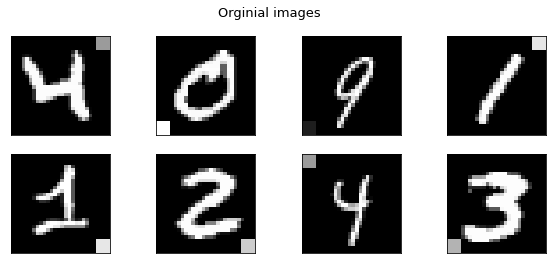

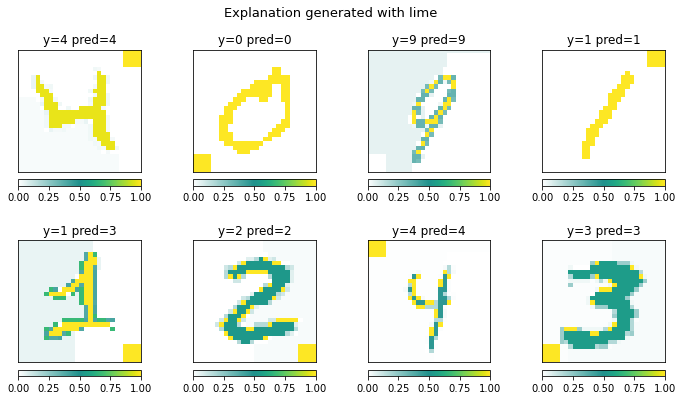

In [5]:
explainer.explain_with_lime(learner.model, train_loader, IMAGE_INDICES)

**IG**

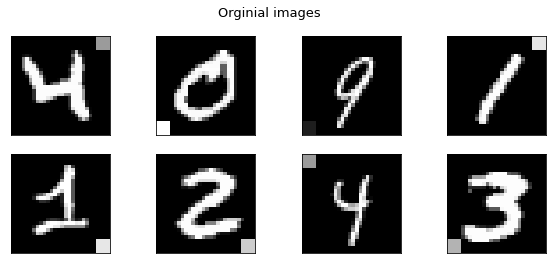

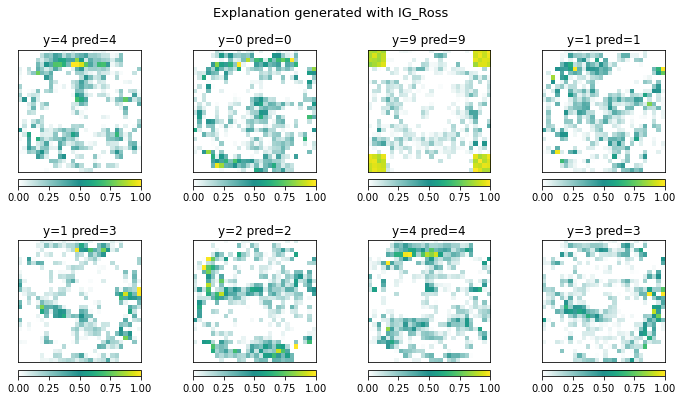

In [6]:
explainer.explain_with_ig(learner.model, train_loader, IMAGE_INDICES)

**Input x Gradient**

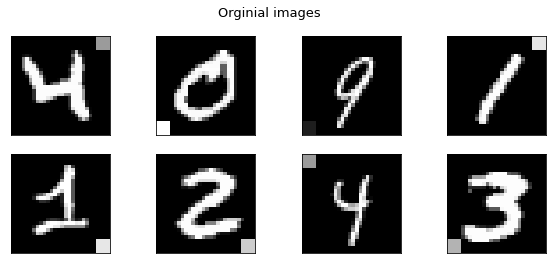

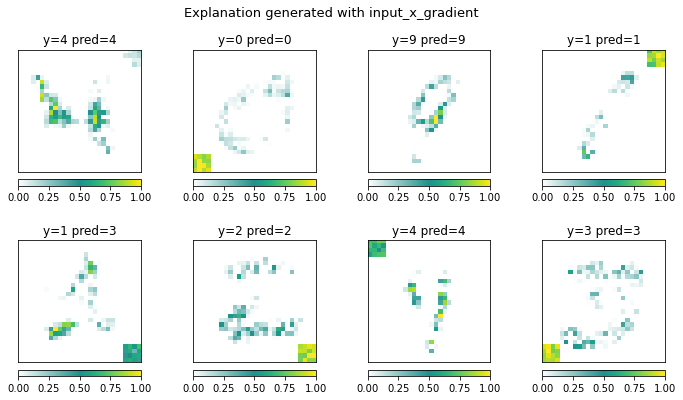

In [7]:
explainer.explain_with_captum('input_x_gradient', learner.model, train_loader, IMAGE_INDICES)

As we can see in the explanations above the model focuses it's predictions predominantly on the confounding factors (the squares)  

## Test set images no XIL

100%|██████████| 1000/1000 [00:00<00:00, 2476.74it/s]


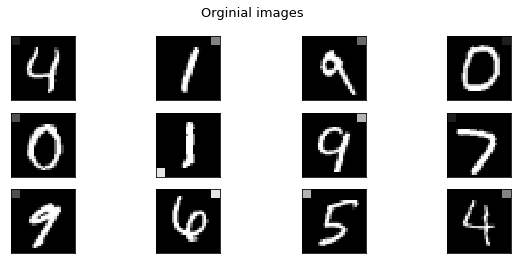

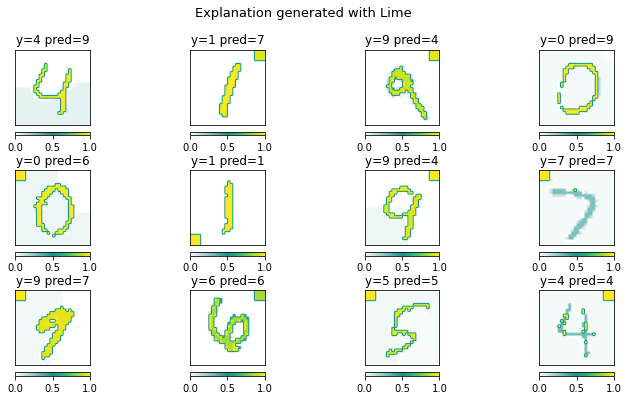

In [58]:
explainer.explain_with_lime(learner.model, test_loader, [4,5,7,10,13,14,16,17,20,22,23,24])

Note: Does Lime really work? 

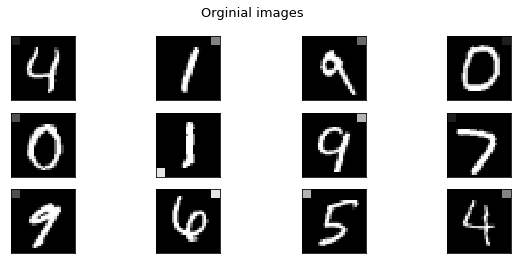

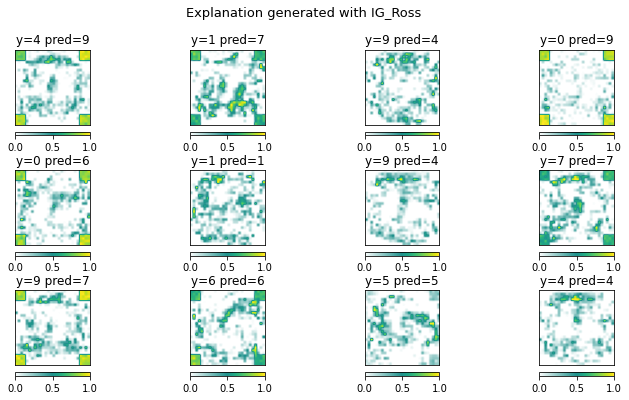

In [57]:
explainer.explain_with_ig(learner.model, test_loader, [4,5,7,10,13,14,16,17,20,22,23,24])

Note: 
* First image -> we can see that the model predicts 9 instead of 4, because the squares is black (as was the case in the train set for nine) - same case for image 2, 4  
* Interestingly, for the image 6 the model makes the right prediction, but does not focus on the confounder (as it is the same in comparison to the train set -> almost white square). Keep in mind, that the model still has a acc of about 60%.  
* in image 10 we have the right answer wrong reason case. 



## Now check predictions explanations with XIL (RRR) model
Load model that was trained on DecoyMNIST with RRR

In [59]:
# Load MLP Model which was trained on DecoyMnist with CrossEntropyLoss
pretrained_modelname = 'DecoyMnist-MLP-RRR--reg=10--seed=10--run=1'
model = dnns.SimpleMlp().to(DEVICE)
loss = RRRLoss(10)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
learner = Learner(model, loss, optimizer, DEVICE, pretrained_modelname, load=True)

print("Score on Train -> ", sep='')
learner.score(train_loader, F.cross_entropy, verbose=True)
print("Score on Test -> ", sep='')
learner.score(test_loader, F.cross_entropy, verbose=True)

Model DecoyMnist-MLP-RRR--reg=10--seed=10--run=1 loaded! Was trained on RRRLoss()!
Score on Train -> 
Test Error: Acc: 98.4%, Avg loss: 0.005791
Score on Test -> 
Test Error: Acc: 95.7%, Avg loss: 0.006017


(95.72, 0.006017387819290161)

### On the Test set as in the example above:

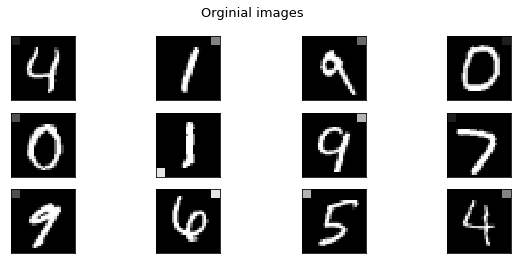

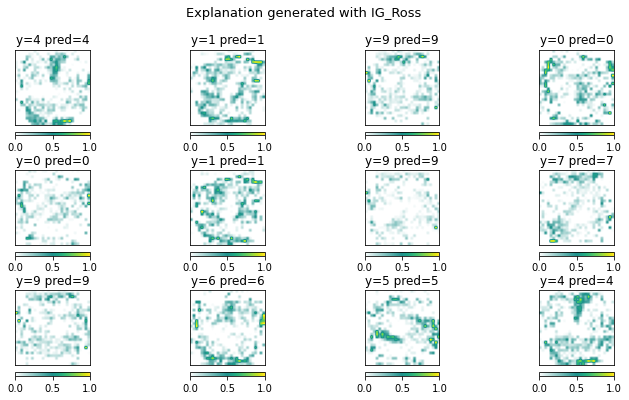

In [60]:
explainer.explain_with_ig(learner.model, test_loader, [4,5,7,10,13,14,16,17,20,22,23,24])

As we can see, the model with the XIL Loss (RRR) does not focus on the corners anymore. It also predicts the right answers.

### Check some more images on the TRAIN set

100%|██████████| 1000/1000 [00:00<00:00, 1526.81it/s]


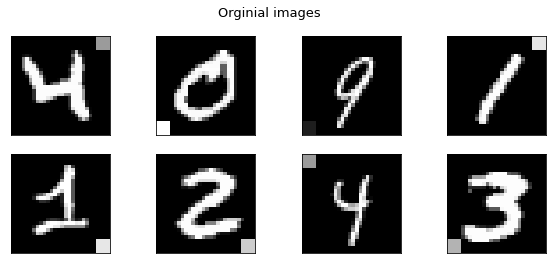

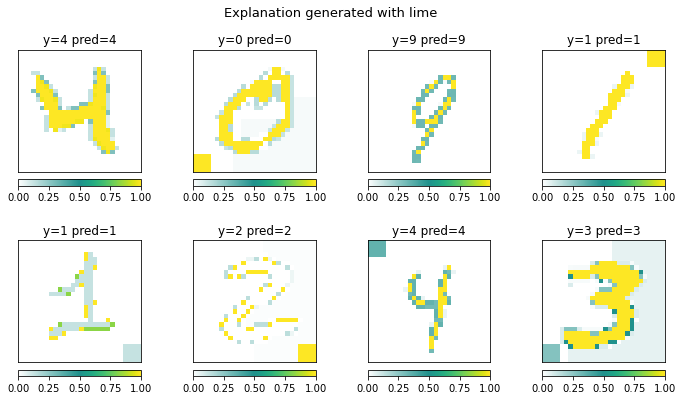

In [15]:
explainer.explain_with_lime(learner.model, train_loader, IMAGE_INDICES)

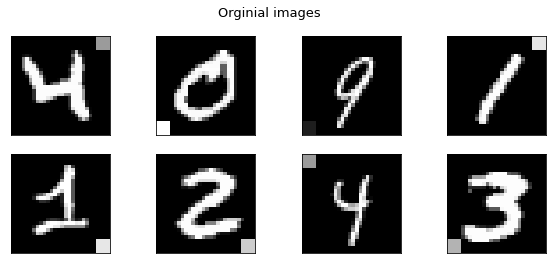

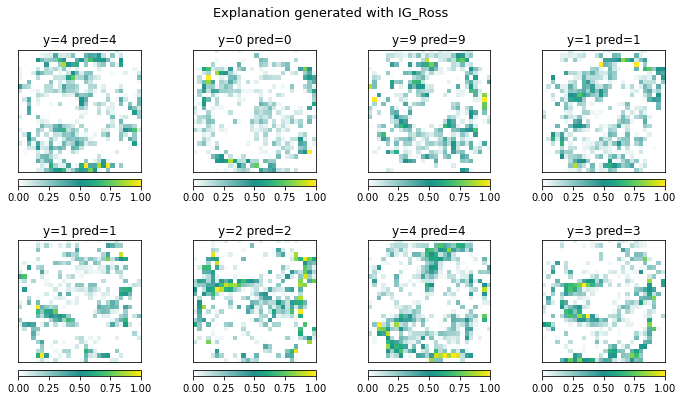

In [16]:
explainer.explain_with_ig(learner.model, train_loader, IMAGE_INDICES)

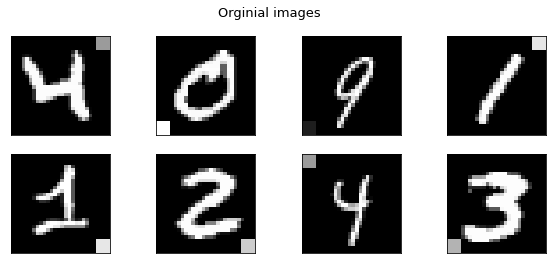

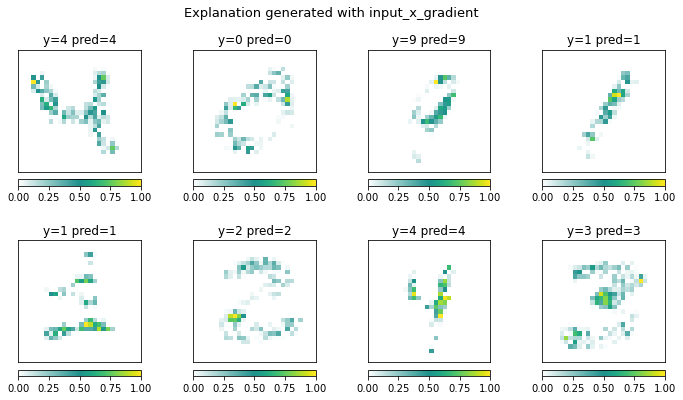

In [17]:
explainer.explain_with_captum('input_x_gradient', learner.model, train_loader, IMAGE_INDICES)

The model trained with RRR does not focus it's predictions predominantly on the squares. For example look at the third top image (9) in the IG prediction. We can see that the corners no longer play a roll. 

## Load pretrained model CNN no XIL 
The model was trained on DecoyMNIST with CrossEntropyLoss. The CNN has two conv layers and thre fc on top of that.

In [13]:
pretrained_modelname = 'DecoyMnist-CNN-CEL--reg=None--seed=10--run=1'
model = dnns.SimpleConvNet().to(DEVICE)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
learner = Learner(model, loss, optimizer, DEVICE, pretrained_modelname, load=True)

print("Score on Train:")
learner.score(train_loader, F.cross_entropy, verbose=True)
print("Score on Test:")
learner.score(test_loader, F.cross_entropy, verbose=True)

Model DecoyMnist-CNN-CEL--reg=None--seed=10--run=1 loaded! Was trained on CrossEntropyLoss()!
Score on Train:
Test Error: Acc: 99.9%, Avg loss: 0.005728
Score on Test:
Test Error: Acc: 75.8%, Avg loss: 0.006807


(75.85, 0.006807028758525849)

### Visualize predictions on train set

**GradCAM**

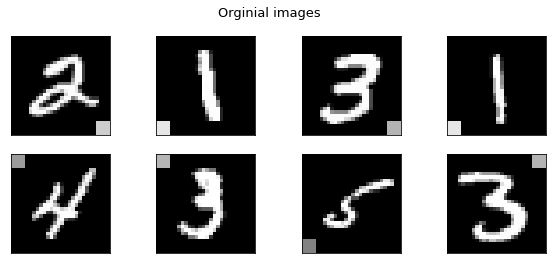

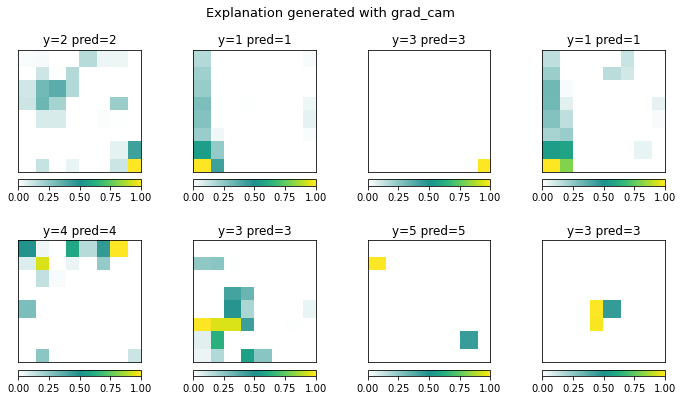

In [20]:
explainer.explain_with_captum('grad_cam', learner.model, train_loader, [5,6,7,8,9,10,11,12])

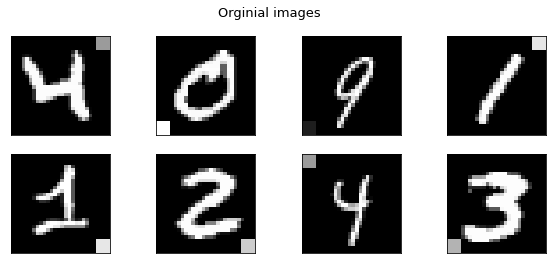

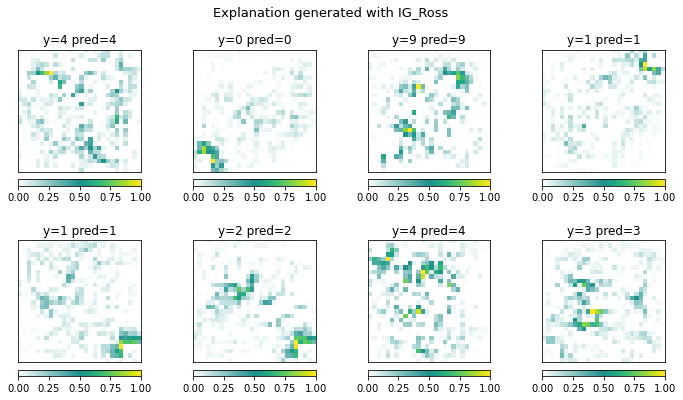

In [5]:
explainer.explain_with_ig(learner.model, train_loader, IMAGE_INDICES)

100%|██████████| 1000/1000 [00:00<00:00, 1076.31it/s]


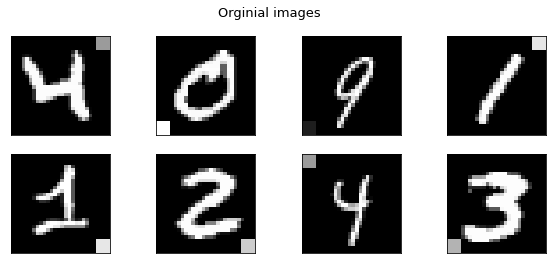

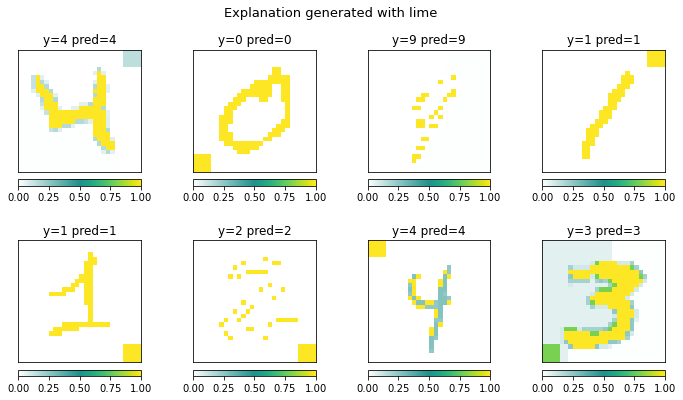

In [6]:
explainer.explain_with_lime(learner.model, train_loader, IMAGE_INDICES)

### Now check performance of RRR CNN Model on DecoyMNIST

In [15]:
pretrained_modelname = 'DecoyMnist-CNN-RRR--reg=10--seed=1--run=0'
model = dnns.SimpleConvNet().to(DEVICE)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
learner = Learner(model, loss, optimizer, DEVICE, pretrained_modelname, load=True)

print("Score on Train:")
learner.score(train_loader, F.cross_entropy, verbose=True)
print("Score on Test:")
learner.score(test_loader, F.cross_entropy, verbose=True)

Model DecoyMnist-CNN-RRR--reg=10--seed=1--run=0 loaded! Was trained on RRRLoss()!
Score on Train:
Test Error: Acc: 99.8%, Avg loss: 0.005731
Score on Test:
Test Error: Acc: 98.8%, Avg loss: 0.005892


(98.81, 0.005892322623729706)

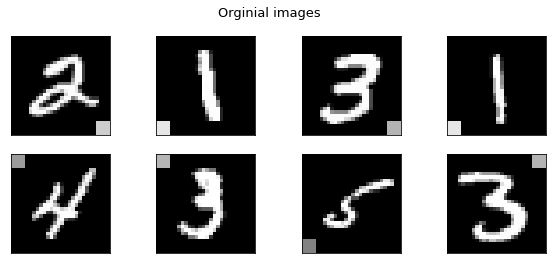

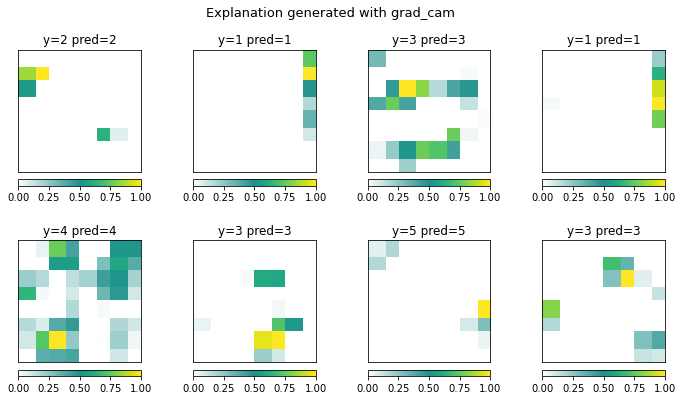

In [8]:
explainer.explain_with_captum('grad_cam', learner.model, train_loader, [5,6,7,8,9,10,11,12])

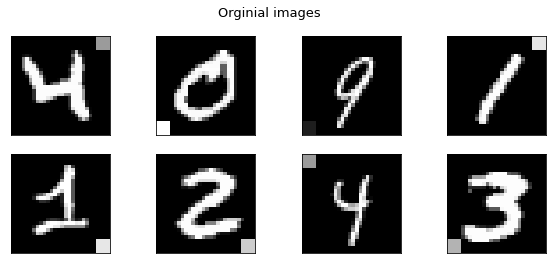

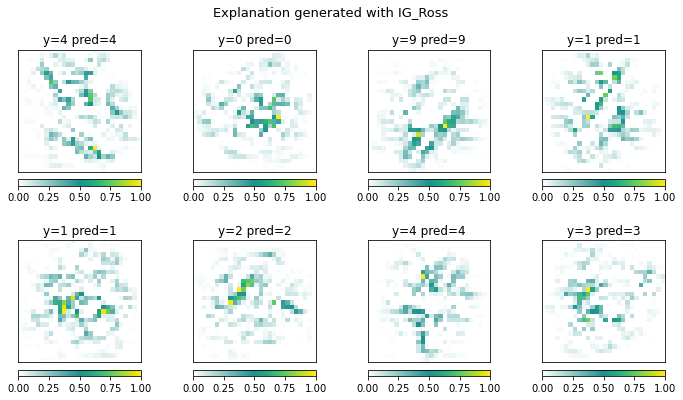

In [9]:
explainer.explain_with_ig(learner.model, train_loader, IMAGE_INDICES)

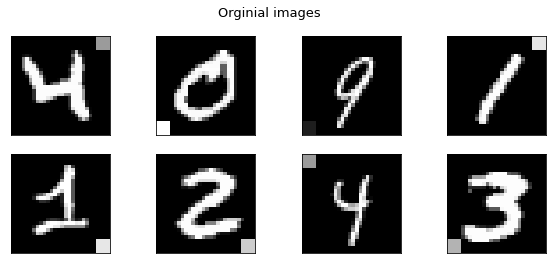

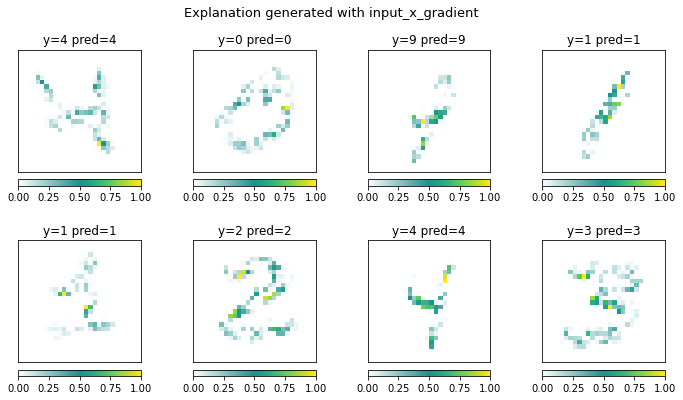

In [10]:
explainer.explain_with_captum('input_x_gradient', learner.model, train_loader, IMAGE_INDICES)

100%|██████████| 1000/1000 [00:01<00:00, 802.18it/s]


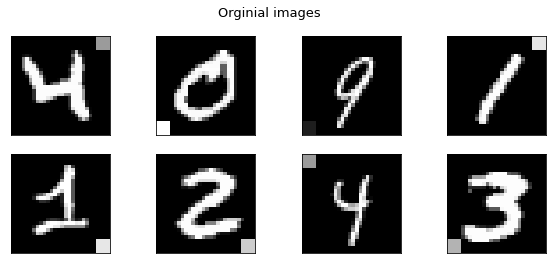

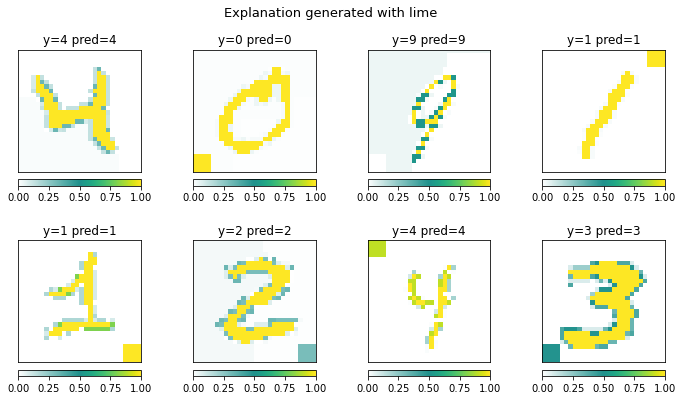

In [11]:
explainer.explain_with_lime(learner.model, train_loader, IMAGE_INDICES)

## Pretrained CNN Model on CE (DecoyMNIST)

In [3]:
pretrained_modelname = 'DecoyMnist-CNN-CE--reg=None--seed=10--run=1'
model = dnns.SimpleConvNet().to(DEVICE)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
learner = Learner(model, loss, optimizer, DEVICE, pretrained_modelname, load=True)

print("Score on Train:")
learner.score(train_loader, F.cross_entropy, verbose=True)
print("Score on Test:")
learner.score(test_loader, F.cross_entropy, verbose=True)

Model DecoyMnist-CNN-CE--reg=None--seed=10--run=1 loaded! Was trained on CrossEntropyLoss()!
Score on Train:
Test Error: Acc: 99.9%, Avg loss: 0.005726
Score on Test:
Test Error: Acc: 98.7%, Avg loss: 0.005897


(98.68, 0.00589665812253952)

100%|██████████| 1000/1000 [00:00<00:00, 1226.65it/s]


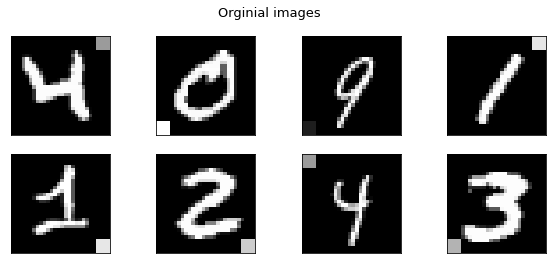

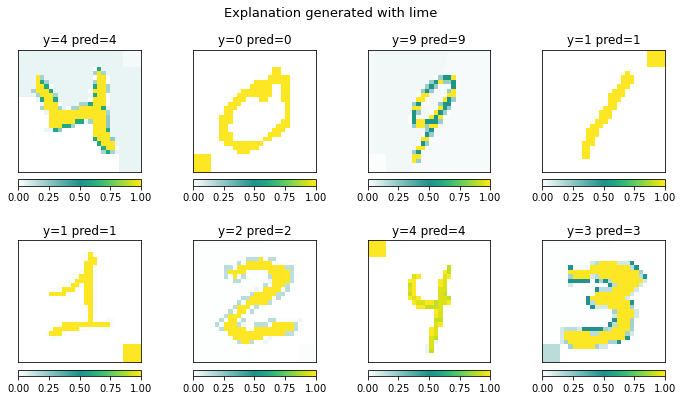

In [4]:
explainer.explain_with_lime(learner.model, train_loader, IMAGE_INDICES)

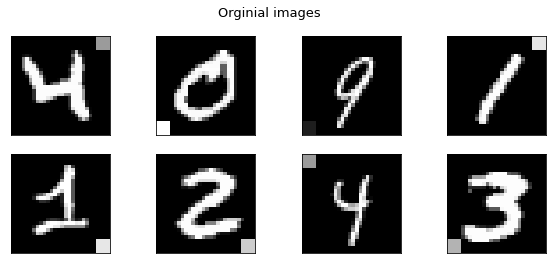

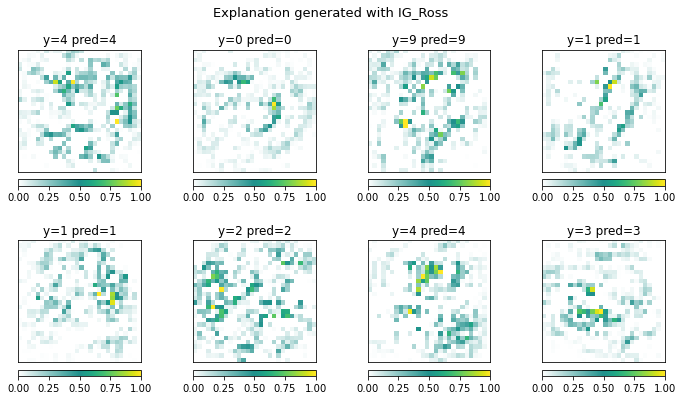

In [27]:
explainer.explain_with_ig(learner.model, train_loader, IMAGE_INDICES, sign='positive')

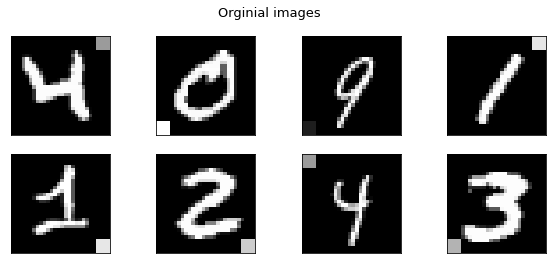

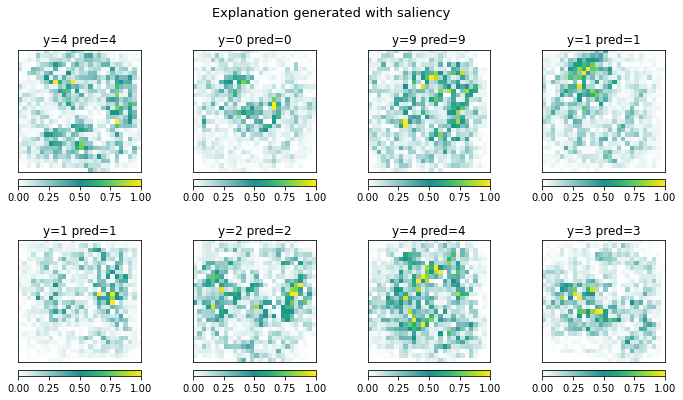

In [26]:
explainer.explain_with_captum('saliency', learner.model, train_loader, IMAGE_INDICES, sign='absolute_value')